**This notebook explores building a machine learning model for deciding if an applicant should be accepted into Tuwaiq programs by predicting whether they're likely to finish a program. EDA and feature selection are carried out in this notebook and three models are tried; KNN, SVM, and XGBoost. SVM performed better than KNN but XGBoost performs the best with F1 score of 0.66115. There is room for improvement, not only with the feature selection but perhaps exploring other methods for model improvement such as doing cross-validation, not doing imputation on the test set, etc.**

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c measuring-student-persistence-and-completion-rate

  0% 0.00/596k [00:00<?, ?B/s]
100% 596k/596k [00:00<00:00, 109MB/s]


In [ ]:
!unzip -q /content/measuring-student-persistence-and-completion-rate.zip

In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/train.csv')
df.head()

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,...,Completed Degree,Level of Education,Education Speaciality,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,Y
0,4f14c50d-162e-4a15-9cf0-ec129c33bcf0,37.0,ذكر,منطقة الرياض,الرياض,453686d8-4023-4506-b2df-fac8b059ac26,PCRF,PCRF,NaN,NaN,...,نعم,البكالوريوس,هندسة حاسب الالي,NaN,2.44,4.0,غير موظف,NaN,NaN,0
1,0599d409-876b-41a5-af05-749ef0e77d32,21.0,ذكر,منطقة عسير,خميس مشيط,cc8e4e42-65d5-4fa1-82f9-6c6c2d508b60,APMR,SWPS,NaN,متوسط,...,نعم,البكالوريوس,الإذاعة والتلفزيون والفيلم,الفنون والعلوم الإنسانية,5.00,5.0,طالب,NaN,NaN,0
2,38a11c0e-4afc-4261-9c64-e94cc0a272fb,24.0,ذكر,منطقة الرياض,الرياض,e006900d-05a9-4c2b-a36f-0ffb9fce44cd,APMR,NaN,NaN,متوسط,...,نعم,البكالوريوس,Information Technology,NaN,3.50,5.0,موظف,NaN,NaN,0
3,1693e85b-f80e-40ce-846f-395ddcece6d3,23.0,ذكر,منطقة الرياض,الرياض,2ec15f6b-233b-428a-b9f5-e40bc8d14cf9,TOSL,TOSL,NaN,NaN,...,نعم,البكالوريوس,حوسبة تطبيقية - (مسار شبكات الحاسب),NaN,3.55,5.0,خريج,NaN,NaN,0
4,98a0e8d0-5f80-4634-afd8-322aa0902863,23.0,ذكر,منطقة الرياض,الرياض,d32da0e9-1aed-48c3-992d-a22f9ccc741e,CAUF,SWPS,تقليدية,متوسط,...,لا,البكالوريوس,نظم المعلومات الحاسوبية,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,NaN,NaN,NaN,0


In [ ]:
df_test = pd.read_csv('/content/test.csv')
df_test.head()

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,...,Program Days,Completed Degree,Level of Education,Education Speaciality,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working
0,d8524ed6-a1b2-4f6f-9041-66eebcab899a,23.0,أنثى,منطقة الرياض,الرياض,451d680f-e067-41c0-a998-6b3da3963bca,CAUF,SWPS,تقليدية,متوسط,...,5,لا,البكالوريوس,علوم الحاسب الالي,NaN,3.72,4.0,خريج,NaN,NaN
1,5490b973-d85e-4b26-93a8-ecc11c47a5a0,31.0,أنثى,منطقة الرياض,الرياض,4957a013-46a7-419c-93d5-ebf3741ab2a1,PCRF,PCRF,تقليدية,مبتدئ,...,19,لا,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,2.00,4.0,NaN,NaN,NaN
2,3c1d99c8-f25b-4198-b904-aacb15164888,29.0,أنثى,منطقة الرياض,الرياض,03ec0d20-11cd-49bf-9b54-de5d12d4bd76,CAUF,SWPS,NaN,NaN,...,12,نعم,البكالوريوس,شبكات الحاسب الآلي,تكنولوجيا الاتصالات والمعلومات,3.72,5.0,موظف,دوام كامل,Yes
3,9e57ee90-2d60-48b8-91a1-7caa49f03810,23.0,أنثى,منطقة الرياض,الرياض,4ad7a7dc-abcf-43fa-b2e3-07095e083661,PCRF,PCRF,NaN,متقدم,...,5,نعم,البكالوريوس,Biology,NaN,4.47,5.0,غير موظف,NaN,NaN
4,a11b482b-6cc3-4e1a-8b95-60ab2e42097a,30.0,أنثى,منطقة الرياض,الرياض,60494e5b-b20a-4440-ab75-0fd257748dcc,TOSL,NaN,داعمة,متقدم,...,33,نعم,الدبلوم,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.46,5.0,غير موظف,دوام كامل,No


In [ ]:
reg = pd.read_csv('registration.csv')

In [ ]:
# Reshape df2 into long format
df2_long = reg.melt(id_vars='Student ID', var_name='Program Main Category Code', value_name='Value')

# Merge df and df2_long based on Program Main Category Code
merged_df = pd.merge(df, df2_long, on=['Student ID', 'Program Main Category Code'], how='left')
merged_df

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,...,Level of Education,Education Speaciality,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,Y,Value
0,4f14c50d-162e-4a15-9cf0-ec129c33bcf0,37.0,ذكر,منطقة الرياض,الرياض,453686d8-4023-4506-b2df-fac8b059ac26,PCRF,PCRF,NaN,NaN,...,البكالوريوس,هندسة حاسب الالي,NaN,2.44,4.0,غير موظف,NaN,NaN,0,4
1,0599d409-876b-41a5-af05-749ef0e77d32,21.0,ذكر,منطقة عسير,خميس مشيط,cc8e4e42-65d5-4fa1-82f9-6c6c2d508b60,APMR,SWPS,NaN,متوسط,...,البكالوريوس,الإذاعة والتلفزيون والفيلم,الفنون والعلوم الإنسانية,5.00,5.0,طالب,NaN,NaN,0,4
2,38a11c0e-4afc-4261-9c64-e94cc0a272fb,24.0,ذكر,منطقة الرياض,الرياض,e006900d-05a9-4c2b-a36f-0ffb9fce44cd,APMR,NaN,NaN,متوسط,...,البكالوريوس,Information Technology,NaN,3.50,5.0,موظف,NaN,NaN,0,0
3,1693e85b-f80e-40ce-846f-395ddcece6d3,23.0,ذكر,منطقة الرياض,الرياض,2ec15f6b-233b-428a-b9f5-e40bc8d14cf9,TOSL,TOSL,NaN,NaN,...,البكالوريوس,حوسبة تطبيقية - (مسار شبكات الحاسب),NaN,3.55,5.0,خريج,NaN,NaN,0,0
4,98a0e8d0-5f80-4634-afd8-322aa0902863,23.0,ذكر,منطقة الرياض,الرياض,d32da0e9-1aed-48c3-992d-a22f9ccc741e,CAUF,SWPS,تقليدية,متوسط,...,البكالوريوس,نظم المعلومات الحاسوبية,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,NaN,NaN,NaN,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6543,cd196579-9590-441b-8787-41078f3cee25,31.0,أنثى,منطقة الرياض,الرياض,4f8c696a-b783-4d40-9776-105f6d3bd624,CAUF,SWPS,NaN,NaN,...,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.40,5.0,NaN,NaN,NaN,0,11
6544,37bfc11c-ff8c-42dc-9cf9-0d13bb8f7131,27.0,أنثى,منطقة القصيم,بريدة,e94942dd-8684-4746-97ae-df567b9b0a4a,PCRF,PCRF,NaN,مبتدئ,...,البكالوريوس,علوم الحاسب,NaN,4.46,5.0,موظف,NaN,NaN,0,0
6545,fc114302-a79f-439f-a08b-fe0a51cf839e,24.0,أنثى,منطقة الرياض,الرياض,02ae0b47-64a6-47a1-b3c5-c0e4df393c30,PCRF,PCRF,تقليدية,مبتدئ,...,البكالوريوس,نظم المعلومات,تكنولوجيا الاتصالات والمعلومات,4.93,5.0,موظف,دوام كامل,Yes,1,6
6546,4b6d9a36-4402-4c75-bc3a-fca927dbaf65,25.0,ذكر,منطقة الرياض,الرياض,9b4cedaa-fac0-4eac-aa4b-b05b6a0c97ff,PCRF,PCRF,NaN,متوسط,...,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.00,4.0,غير موظف,تدريب,No,0,0


merge registration.csv dataframe with the train.csv dataframe to see the number of times that the applicant applied for the program in which they got accepted

if they applied 0 times but got accepted it could be because its not their first choice so they may not complete the program


In [ ]:
# Reshape df2 into long format
df2_long_2 = reg.melt(id_vars='Student ID', var_name='Program Main Category Code', value_name='Value')

# Merge df_test and df2_long based on Program Main Category Code
merged_df_2 = pd.merge(df_test, df2_long_2, on=['Student ID', 'Program Main Category Code'], how='left')
merged_df_2

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,...,Completed Degree,Level of Education,Education Speaciality,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,Value
0,d8524ed6-a1b2-4f6f-9041-66eebcab899a,23.0,أنثى,منطقة الرياض,الرياض,451d680f-e067-41c0-a998-6b3da3963bca,CAUF,SWPS,تقليدية,متوسط,...,لا,البكالوريوس,علوم الحاسب الالي,NaN,3.72,4.0,خريج,NaN,NaN,1
1,5490b973-d85e-4b26-93a8-ecc11c47a5a0,31.0,أنثى,منطقة الرياض,الرياض,4957a013-46a7-419c-93d5-ebf3741ab2a1,PCRF,PCRF,تقليدية,مبتدئ,...,لا,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,2.00,4.0,NaN,NaN,NaN,0
2,3c1d99c8-f25b-4198-b904-aacb15164888,29.0,أنثى,منطقة الرياض,الرياض,03ec0d20-11cd-49bf-9b54-de5d12d4bd76,CAUF,SWPS,NaN,NaN,...,نعم,البكالوريوس,شبكات الحاسب الآلي,تكنولوجيا الاتصالات والمعلومات,3.72,5.0,موظف,دوام كامل,Yes,1
3,9e57ee90-2d60-48b8-91a1-7caa49f03810,23.0,أنثى,منطقة الرياض,الرياض,4ad7a7dc-abcf-43fa-b2e3-07095e083661,PCRF,PCRF,NaN,متقدم,...,نعم,البكالوريوس,Biology,NaN,4.47,5.0,غير موظف,NaN,NaN,7
4,a11b482b-6cc3-4e1a-8b95-60ab2e42097a,30.0,أنثى,منطقة الرياض,الرياض,60494e5b-b20a-4440-ab75-0fd257748dcc,TOSL,NaN,داعمة,متقدم,...,نعم,الدبلوم,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.46,5.0,غير موظف,دوام كامل,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,c4bd99a6-2902-4822-947e-2a3aab3f1e92,36.0,ذكر,منطقة الرياض,الرياض,1b546d80-2ed0-42e6-9867-61b3d2f92d50,GRST,INFA,NaN,متوسط,...,نعم,البكالوريوس,علوم حاسب,NaN,2.55,5.0,موظف,NaN,NaN,1
814,2e057846-ee90-4b31-b6e7-c1c5122f4cbd,29.0,ذكر,منطقة الرياض,الرياض,aa87165d-cbde-4453-baca-1c8c03775e39,CAUF,CRDP,داعمة,مبتدئ,...,نعم,البكالوريوس,الهندسة الكهربائية,الهندسة والتصنيع والبناء,3.00,4.0,NaN,NaN,NaN,1
815,8f9ff50d-510c-4d56-b0eb-60c2fb1c5e84,32.0,ذكر,منطقة الرياض,الرياض,c49987af-b421-4b88-b36a-a0ec91d95aa3,GRST,INFA,تقليدية,متوسط,...,نعم,البكالوريوس,شبكات حاسب,NaN,3.00,5.0,موظف,NaN,NaN,2
816,8a49b6cd-e7c3-460b-8126-a419cf995e6e,28.0,أنثى,منطقة الرياض,الرياض,899795e1-7bf3-46d0-a58e-824d4033f6da,PCRF,PCRF,تقليدية,متوسط,...,لا,البكالوريوس,نظم معلومات حاسوبية,NaN,4.12,5.0,غير موظف,NaN,NaN,4


In [ ]:
df = merged_df
df_test = merged_df_2

In [ ]:
df.describe()

,Age,Program Days,University Degree Score,University Degree Score System,Y,Value
count,6456.000000,6548.000000,6467.000000,6467.000000,6548.000000,6548.000000
mean,26.831165,19.691662,8.224432,9.773929,0.158674,2.920739
std,5.535967,32.112061,19.120384,21.259962,0.365400,4.243394
min,18.000000,3.000000,0.000000,4.000000,0.000000,0.000000
25%,23.000000,5.000000,3.300000,5.000000,0.000000,0.000000
50%,25.000000,12.000000,4.000000,5.000000,0.000000,1.000000
75%,29.000000,19.000000,4.510000,5.000000,0.000000,4.000000
max,57.000000,292.000000,100.000000,100.000000,1.000000,45.000000


In [ ]:
df.columns

Index(['Student ID', 'Age', 'Gender', 'Home Region', 'Home City', 'Program ID',
       'Program Main Category Code', 'Program Sub Category Code',
       'Technology Type', 'Program Skill Level', 'Program Presentation Method',
       'Program Start Date', 'Program End Date', 'Program Days',
       'Completed Degree', 'Level of Education', 'Education Speaciality',
       'College', 'University Degree Score', 'University Degree Score System',
       'Employment Status', 'Job Type', 'Still Working', 'Y', 'Value'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6548 entries, 0 to 6547
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Student ID                      6548 non-null   object 
 1   Age                             6456 non-null   float64
 2   Gender                          6548 non-null   object 
 3   Home Region                     6546 non-null   object 
 4   Home City                       6546 non-null   object 
 5   Program ID                      6548 non-null   object 
 6   Program Main Category Code      6548 non-null   object 
 7   Program Sub Category Code       5613 non-null   object 
 8   Technology Type                 3566 non-null   object 
 9   Program Skill Level             4902 non-null   object 
 10  Program Presentation Method     6548 non-null   object 
 11  Program Start Date              6548 non-null   object 
 12  Program End Date                65

In [ ]:
df.nunique()

Student ID                        5196
Age                                 39
Gender                               2
Home Region                         13
Home City                           92
Program ID                         223
Program Main Category Code          10
Program Sub Category Code           11
Technology Type                      3
Program Skill Level                  3
Program Presentation Method          2
Program Start Date                  77
Program End Date                    88
Program Days                        25
Completed Degree                     2
Level of Education                   5
Education Speaciality              871
College                              9
University Degree Score            435
University Degree Score System       3
Employment Status                    6
Job Type                             4
Still Working                        2
Y                                    2
Value                               31
dtype: int64

In [ ]:
df.duplicated().sum()

48

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.columns[df.isnull().any()]

Index(['Age', 'Home Region', 'Home City', 'Program Sub Category Code',
       'Technology Type', 'Program Skill Level', 'Level of Education',
       'Education Speaciality', 'College', 'University Degree Score',
       'University Degree Score System', 'Employment Status', 'Job Type',
       'Still Working'],
      dtype='object')

In [ ]:
df.isnull().sum()

Student ID                           0
Age                                 87
Gender                               0
Home Region                          2
Home City                            2
Program ID                           0
Program Main Category Code           0
Program Sub Category Code          920
Technology Type                   2958
Program Skill Level               1645
Program Presentation Method          0
Program Start Date                   0
Program End Date                     0
Program Days                         0
Completed Degree                     0
Level of Education                  22
Education Speaciality              272
College                           3862
University Degree Score             76
University Degree Score System      76
Employment Status                  557
Job Type                          4535
Still Working                     4535
Y                                    0
Value                                0
dtype: int64

Job type and Still working contain a high % of nan compared with the total # of records so these columns can be dropped.

Age can be replaced with the mean/mode.

The home region, the city, the degree score and system can be replaced with the previous value.



<Axes: xlabel='Y', ylabel='Value'>

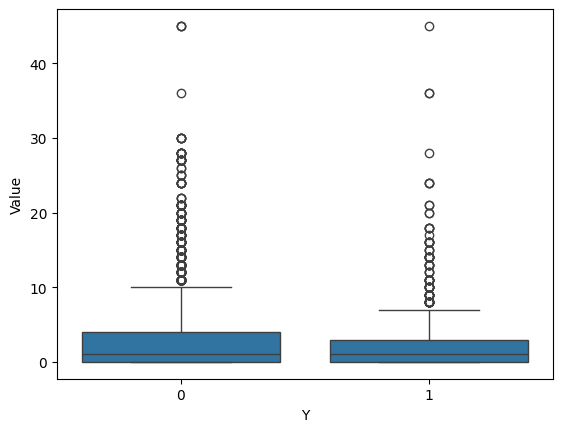

In [ ]:
sns.boxplot(x='Y', y='Value', data=df)

fewer number of registrations complete the course over those who don't complete but there are outliers which indicate higher number of registrations also complete the course



<Axes: xlabel='Y', ylabel='Age'>

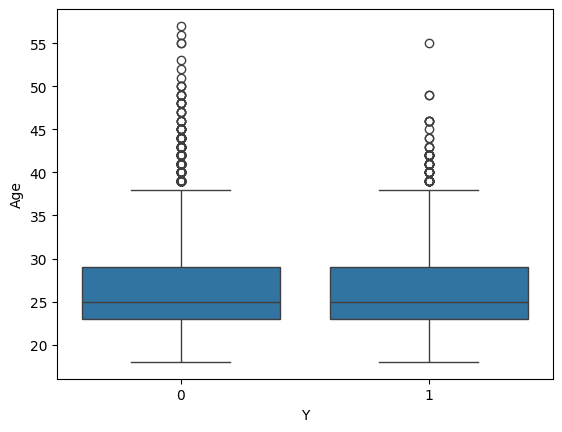

In [ ]:
sns.boxplot(x='Y', y='Age', data=df)

people within the same age range don't show a relationship as to whether they complete or not

In [ ]:
df.groupby(['Gender'])['Y'].value_counts()

Gender  Y
أنثى    0    3052
        1     599
ذكر     0    2409
        1     440
Name: Y, dtype: int64

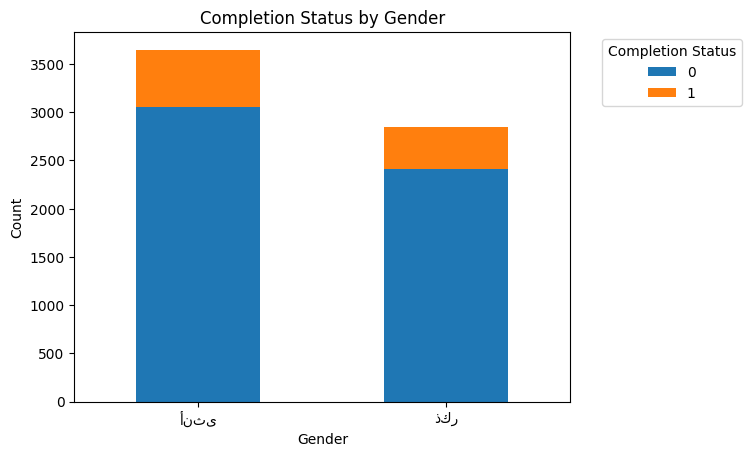

In [ ]:
grouped = df.groupby(['Gender', 'Y']).size().unstack(fill_value=0)

# Plot stacked bar plot
grouped.plot(kind='bar', stacked=True)
plt.title('Completion Status by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Completion Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Axes: xlabel='Gender', ylabel='count'>

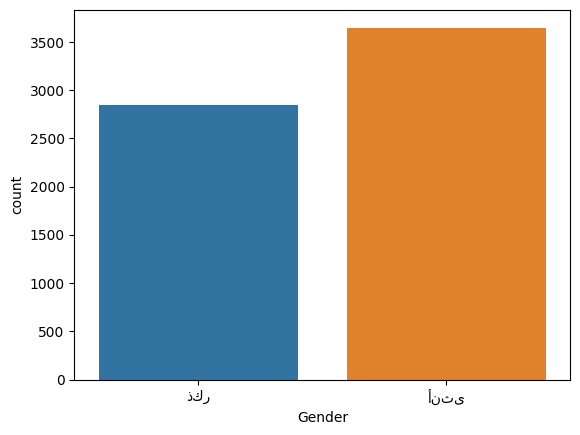

In [ ]:
sns.countplot(data=df, x=df['Gender'], hue=df['Gender'])

there are more females than males and more females complete the course than males

23.0

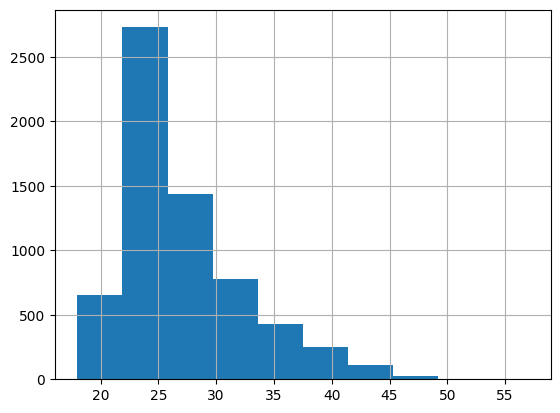

In [ ]:
df['Age'].hist()
df['Age'].mode()[0]

In [ ]:
df['Age'].fillna(df['Age'].mode()[0], inplace=True)

In [ ]:
df['Age'].isnull().any()

False

In [ ]:
df.describe()

,Age,Program Days,University Degree Score,University Degree Score System,Y,Value
count,6500.000000,6500.000000,6424.000000,6424.000000,6500.000000,6500.000000
mean,26.771077,19.661692,8.242163,9.792964,0.159846,2.929231
std,5.515876,32.189476,19.153997,21.297309,0.366492,4.251145
min,18.000000,3.000000,0.000000,4.000000,0.000000,0.000000
25%,23.000000,5.000000,3.300000,5.000000,0.000000,0.000000
50%,25.000000,12.000000,4.000000,5.000000,0.000000,1.000000
75%,29.000000,19.000000,4.510000,5.000000,0.000000,4.000000
max,57.000000,292.000000,100.000000,100.000000,1.000000,45.000000


std of age became 5.51 from 5.53 so there isn't much difference and we can use mode to impute

In [ ]:
df['Job Type'].value_counts()

دوام كامل    1386
تدريب         474
دوام جزئي      61
تطوع           44
Name: Job Type, dtype: int64

In [ ]:
df.drop(columns=['Job Type', 'Still Working'], axis=1, inplace=True)

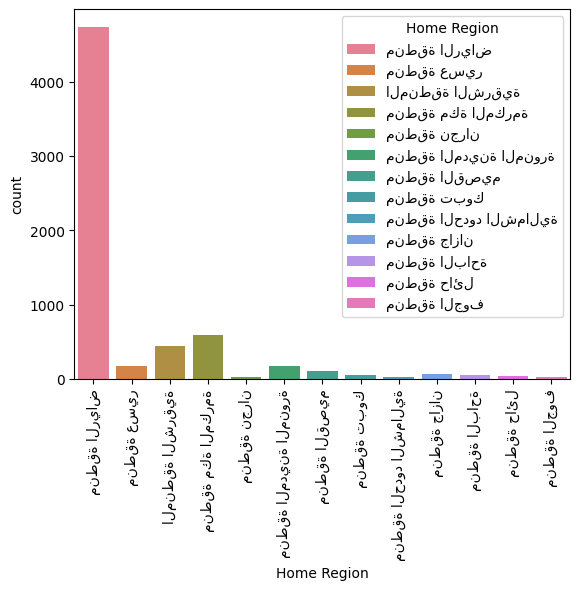

In [ ]:
sns.countplot(data=df, x=df['Home Region'], hue=df['Home Region'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
df['Home City'].value_counts()

الرياض             4678
جدة                 361
المدينة المنورة     131
الدمام              119
أبها                109
                   ... 
بيش                   1
المجاردة              1
العرضيات              1
الحناكية              1
أملج                  1
Name: Home City, Length: 92, dtype: int64

most regions and city values are of Riyadh which makes sense since Tuwaiq is in Riyadh so we can drop it

In [ ]:
df['University Degree Score'].fillna(method='ffill', inplace=True)

In [ ]:
df['University Degree Score System'].fillna(method='ffill', inplace=True)

In [ ]:
df['Program Sub Category Code'].value_counts()

SWPS    1786
PCRF    1657
SRTA     698
INFA     509
TOSL     294
CRDP     243
ERST     172
KLTM     117
QTDY      49
ASCW      36
ABIR      19
Name: Program Sub Category Code, dtype: int64

same values as main category code, can drop it

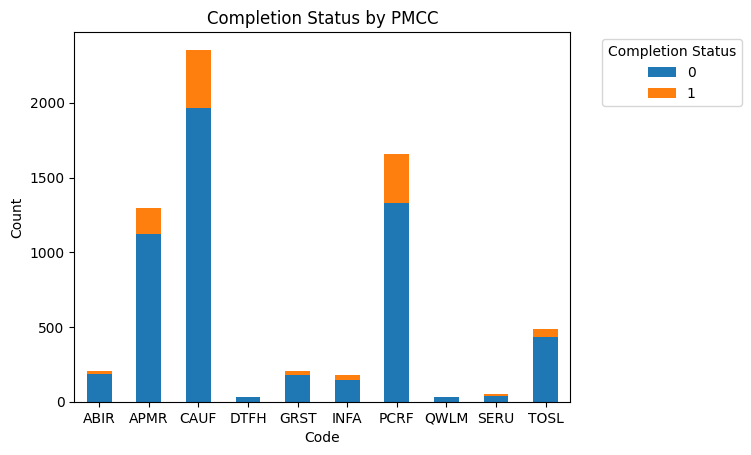

In [ ]:
grouped = df.groupby(['Program Main Category Code', 'Y']).size().unstack(fill_value=0)

# Plot stacked bar plot
grouped.plot(kind='bar', stacked=True)
plt.title('Completion Status by PMCC')
plt.xlabel('Code')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Completion Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
df['Technology Type'].value_counts()

تقليدية    2670
ناشئة       440
داعمة       432
Name: Technology Type, dtype: int64

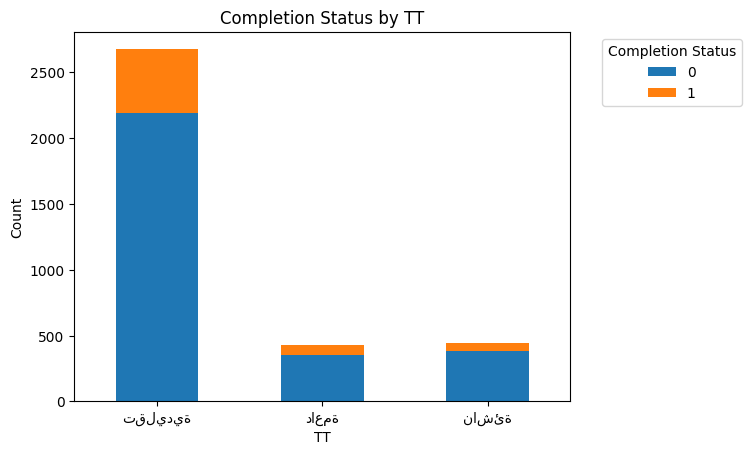

In [ ]:
grouped = df.groupby(['Technology Type', 'Y']).size().unstack(fill_value=0)

# Plot stacked bar plot
grouped.plot(kind='bar', stacked=True)
plt.title('Completion Status by TT')
plt.xlabel('TT')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Completion Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

traditional
emerging?
supportive?

most of the ones belonging to the first category complete it

In [ ]:
df['Program Skill Level'].value_counts()

متوسط    2105
مبتدئ    2053
متقدم     697
Name: Program Skill Level, dtype: int64

average, beginner, advanced

In [ ]:
df['Level of Education'].value_counts()

البكالوريوس    5391
الماجستير       481
الدبلوم         309
ثانوي           267
الدكتوراه        30
Name: Level of Education, dtype: int64

bachelor, masters, diploma, secondary, phd


In [ ]:
df['Education Speaciality'].unique()

array(['هندسة حاسب الالي', 'الإذاعة والتلفزيون والفيلم',
       'Information Technology', 'حوسبة تطبيقية - (مسار شبكات الحاسب)',
       'نظم المعلومات الحاسوبية', 'هندسة حاسب آلي', 'نظم معلومات',
       'علوم وهندسة الحاسب الآلي', 'نظم المعلومات', 'علوم الحاسبات',
       'علوم حاسب الي', 'تقنية المعلومات', 'Software Engineering',
       'Computer Networking and Cyber security', 'الجغرافيا البشرية',
       'علوم وهندسة الحاسب - ذكاء اصطناعي',
       'Civil and Environmental engineering', 'علوم الحاسب الالي',
       'الرياضيات التطبيقية', 'أمن المعلومات', 'شبكات الحاسب الآلي',
       'علوم الحاسب', 'لغويات تطبيقية', 'علوم حاسب', 'تصميم منتجات',
       'computer science', 'تاريخ اسلامي', nan, 'هندسة شبكات',
       'تطبيقات الحاسب الالي', 'هندسة كهربائية', 'Software engineering',
       'تاريخ', 'علوم حاسب آلي', 'شبكات الحاسب', 'هندسة البرمجيات',
       'نظم معلومات حاسوبيه-قواعد بيانات', 'product design',
       'management information system', 'ENGINEER IN MARINE TECHNOLOGY',
       'اله

just drop it

In [ ]:
df['College'].unique()

array([nan, 'الفنون والعلوم الإنسانية', 'تكنولوجيا الاتصالات والمعلومات',
       'العلوم الاجتماعية والصحافة والإعلام',
       'العلوم الطبيعية والرياضيات والإحصاء', 'الهندسة والتصنيع والبناء',
       'الأعمال والإدارة والقانون', 'التعليم', 'الصحة والرفاة',
       'البرامج والمؤهلات العامة'], dtype=object)

can drop, has high % of nan

In [ ]:
df['Employment Status'].unique()

array(['غير موظف', 'طالب', 'موظف', 'خريج', nan, 'موظف - طالب', 'عمل حر'],
      dtype=object)

'Unemployed', 'student', 'employee', 'graduate', nan, 'employee-student', 'self-employed'

In [ ]:
df['Employment Status'].fillna(df['Employment Status'].mode()[0], inplace=True)

In [ ]:
df.describe()

,Age,Program Days,University Degree Score,University Degree Score System,Y,Value
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,26.771077,19.661692,8.306759,9.837538,0.159846,2.929231
std,5.515876,32.189476,19.303799,21.384472,0.366492,4.251145
min,18.000000,3.000000,0.000000,4.000000,0.000000,0.000000
25%,23.000000,5.000000,3.300000,5.000000,0.000000,0.000000
50%,25.000000,12.000000,4.000000,5.000000,0.000000,1.000000
75%,29.000000,19.000000,4.510000,5.000000,0.000000,4.000000
max,57.000000,292.000000,100.000000,100.000000,1.000000,45.000000


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_std = StandardScaler()
df[['Program Days', 'University Degree Score', 'University Degree Score System', 'Value']] = scaler_std.fit_transform(df[['Program Days', 'University Degree Score', 'University Degree Score System', 'Value']])

days, score, score system, and value have very high standard deviation compared with the mean so applying standardization

In [ ]:
df.drop(columns=['Education Speaciality', 'College'], axis=1, inplace=True)

In [ ]:
df.isnull().sum()

Student ID                           0
Age                                  0
Gender                               0
Home Region                          2
Home City                            2
Program ID                           0
Program Main Category Code           0
Program Sub Category Code          920
Technology Type                   2958
Program Skill Level               1645
Program Presentation Method          0
Program Start Date                   0
Program End Date                     0
Program Days                         0
Completed Degree                     0
Level of Education                  22
University Degree Score              0
University Degree Score System       0
Employment Status                    0
Y                                    0
Value                                0
dtype: int64

In [ ]:
df['Program Skill Level'].fillna(df['Program Skill Level'].mode()[0], inplace=True)

In [ ]:
df['Technology Type'].fillna(df['Technology Type'].mode()[0], inplace=True)

In [ ]:
df['Program ID']

0       453686d8-4023-4506-b2df-fac8b059ac26
1       cc8e4e42-65d5-4fa1-82f9-6c6c2d508b60
2       e006900d-05a9-4c2b-a36f-0ffb9fce44cd
3       2ec15f6b-233b-428a-b9f5-e40bc8d14cf9
4       d32da0e9-1aed-48c3-992d-a22f9ccc741e
                        ...                 
6543    4f8c696a-b783-4d40-9776-105f6d3bd624
6544    e94942dd-8684-4746-97ae-df567b9b0a4a
6545    02ae0b47-64a6-47a1-b3c5-c0e4df393c30
6546    9b4cedaa-fac0-4eac-aa4b-b05b6a0c97ff
6547    d8fbc53c-e042-4e45-b8c7-42b4ad0528ee
Name: Program ID, Length: 6500, dtype: object

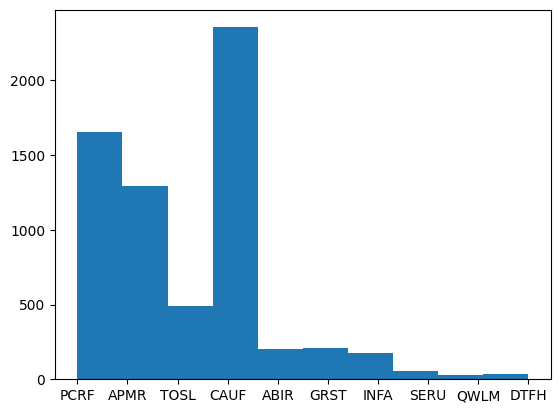

In [ ]:
plt.hist(df['Program Main Category Code'], bins=10)
plt.show()

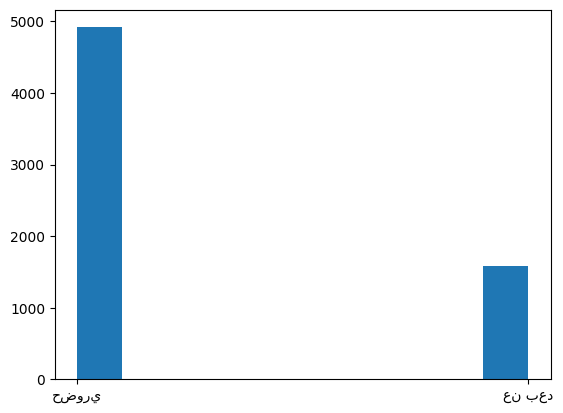

حضوري     4918
عن بعد    1582
Name: Program Presentation Method, dtype: int64

In [ ]:
plt.hist(df['Program Presentation Method'], bins=10)
plt.show()
df['Program Presentation Method'].value_counts()

In [ ]:
df['Completed Degree'].value_counts()

نعم    5160
لا     1340
Name: Completed Degree, dtype: int64

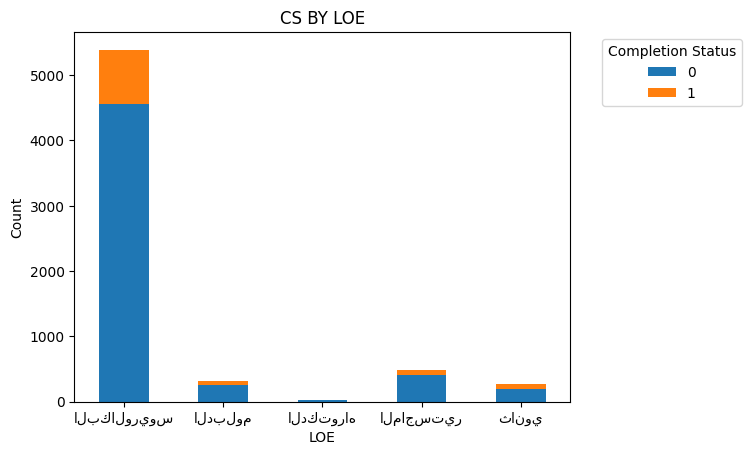

In [ ]:
grouped = df.groupby(['Level of Education', 'Y']).size().unstack(fill_value=0)

# Plot stacked bar plot
grouped.plot(kind='bar', stacked=True)
plt.title('CS BY LOE')
plt.xlabel('LOE')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Completion Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

most under first category, can drop it

In [ ]:
df.columns

Index(['Student ID', 'Age', 'Gender', 'Home Region', 'Home City', 'Program ID',
       'Program Main Category Code', 'Program Sub Category Code',
       'Technology Type', 'Program Skill Level', 'Program Presentation Method',
       'Program Start Date', 'Program End Date', 'Program Days',
       'Completed Degree', 'Level of Education', 'University Degree Score',
       'University Degree Score System', 'Employment Status', 'Y', 'Value'],
      dtype='object')

In [ ]:
df.drop(columns=['Level of Education', 'Program ID', 'Student ID', 'Home Region', 'Home City', 'Program Sub Category Code', 'Program Start Date', 'Program End Date'], axis=1, inplace=True)

dropped columns that feel irrelevant :o

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6547
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             6500 non-null   float64
 1   Gender                          6500 non-null   object 
 2   Program Main Category Code      6500 non-null   object 
 3   Technology Type                 6500 non-null   object 
 4   Program Skill Level             6500 non-null   object 
 5   Program Presentation Method     6500 non-null   object 
 6   Program Days                    6500 non-null   float64
 7   Completed Degree                6500 non-null   object 
 8   University Degree Score         6500 non-null   float64
 9   University Degree Score System  6500 non-null   float64
 10  Employment Status               6500 non-null   object 
 11  Y                               6500 non-null   int64  
 12  Value                           65

In [ ]:
df.isnull().sum()

Age                               0
Gender                            0
Program Main Category Code        0
Technology Type                   0
Program Skill Level               0
Program Presentation Method       0
Program Days                      0
Completed Degree                  0
University Degree Score           0
University Degree Score System    0
Employment Status                 0
Y                                 0
Value                             0
dtype: int64

In [ ]:
one_hot_encoded_category1 = pd.get_dummies(df['Gender'], prefix=' Gender')
one_hot_encoded_category2 = pd.get_dummies(df['Program Main Category Code'], prefix='Program Main Category Code')
one_hot_encoded_category5 = pd.get_dummies(df['Program Skill Level'], prefix='Program Skill Level')
one_hot_encoded_category6 = pd.get_dummies(df['Program Presentation Method'], prefix='Program Presentation Method')
one_hot_encoded_category7 = pd.get_dummies(df['Completed Degree'], prefix='Completed Degree')
one_hot_encoded_category9 = pd.get_dummies(df['Employment Status'], prefix='Employment Status')
one_hot_encoded_category10 = pd.get_dummies(df['Technology Type'], prefix='Technology Type')
df_encoded = pd.concat([df, one_hot_encoded_category1, one_hot_encoded_category2, one_hot_encoded_category5, one_hot_encoded_category6, one_hot_encoded_category7, one_hot_encoded_category9, one_hot_encoded_category10], axis=1)
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6547
Data columns (total 41 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 6500 non-null   float64
 1   Gender                              6500 non-null   object 
 2   Program Main Category Code          6500 non-null   object 
 3   Technology Type                     6500 non-null   object 
 4   Program Skill Level                 6500 non-null   object 
 5   Program Presentation Method         6500 non-null   object 
 6   Program Days                        6500 non-null   float64
 7   Completed Degree                    6500 non-null   object 
 8   University Degree Score             6500 non-null   float64
 9   University Degree Score System      6500 non-null   float64
 10  Employment Status                   6500 non-null   object 
 11  Y                                   6500 no

In [ ]:
df_encoded.drop(columns=['Gender', 'Technology Type','Program Main Category Code', 'Program Skill Level', 'Program Presentation Method', 'Completed Degree', 'Employment Status'], axis=1, inplace=True)

In [ ]:
df_encoded.head()

,Age,Program Days,University Degree Score,University Degree Score System,Y,Value,Gender_أنثى,Gender_ذكر,Program Main Category Code_ABIR,Program Main Category Code_APMR,...,Completed Degree_نعم,Employment Status_خريج,Employment Status_طالب,Employment Status_عمل حر,Employment Status_غير موظف,Employment Status_موظف,Employment Status_موظف - طالب,Technology Type_تقليدية,Technology Type_داعمة,Technology Type_ناشئة
0,37.0,-0.238037,-0.303941,-0.273001,0,0.251897,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
1,21.0,-0.455516,-0.171314,-0.226235,0,0.251897,0,1,0,1,...,1,0,1,0,0,0,0,1,0,0
2,24.0,1.066838,-0.249025,-0.226235,0,-0.689098,0,1,0,1,...,1,0,0,0,0,1,0,1,0,0
3,23.0,0.414400,-0.246435,-0.226235,0,-0.689098,0,1,0,0,...,1,1,0,0,0,0,0,1,0,0
4,23.0,1.066838,-0.223121,-0.226235,0,0.251897,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
df_encoded.columns

Index(['Age', 'Program Days', 'University Degree Score',
       'University Degree Score System', 'Y', 'Value', ' Gender_أنثى',
       ' Gender_ذكر', 'Program Main Category Code_ABIR',
       'Program Main Category Code_APMR', 'Program Main Category Code_CAUF',
       'Program Main Category Code_DTFH', 'Program Main Category Code_GRST',
       'Program Main Category Code_INFA', 'Program Main Category Code_PCRF',
       'Program Main Category Code_QWLM', 'Program Main Category Code_SERU',
       'Program Main Category Code_TOSL', 'Program Skill Level_مبتدئ',
       'Program Skill Level_متقدم', 'Program Skill Level_متوسط',
       'Program Presentation Method_حضوري',
       'Program Presentation Method_عن بعد', 'Completed Degree_لا',
       'Completed Degree_نعم', 'Employment Status_خريج',
       'Employment Status_طالب', 'Employment Status_عمل حر',
       'Employment Status_غير موظف', 'Employment Status_موظف',
       'Employment Status_موظف - طالب', 'Technology Type_تقليدية',
       'Tec

In [ ]:
X_train = df_encoded.drop('Y',axis=1)
y_train = df_encoded['Y']

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# k=9
# classifier = KNeighborsClassifier(k)
# classifier.fit(X_train,y_train)

In [1]:
# from sklearn.svm import SVC
# svm_model = SVC(kernel='linear')
# svm_model.fit(X_train, y_train)

In [ ]:
df_test.isnull().sum()

Student ID                          0
Age                                14
Gender                              0
Home Region                         1
Home City                           1
Program ID                          0
Program Main Category Code          0
Program Sub Category Code         115
Technology Type                   364
Program Skill Level               200
Program Presentation Method         0
Program Start Date                  0
Program End Date                    0
Program Days                        0
Completed Degree                    0
Level of Education                  3
Education Speaciality              37
College                           492
University Degree Score            11
University Degree Score System     11
Employment Status                  70
Job Type                          581
Still Working                     581
Value                               0
dtype: int64

In [ ]:
df_test.drop(columns=['Student ID', 'Level of Education', 'Home Region', 'Home City', 'Program ID', 'Program Sub Category Code', 'Program Start Date', 'Program End Date', 'Education Speaciality', 'College', 'Job Type'], axis=1, inplace=True)

In [ ]:
df_test.drop(columns=['Still Working'],axis=1, inplace=True)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 0 to 817
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             804 non-null    float64
 1   Gender                          818 non-null    object 
 2   Program Main Category Code      818 non-null    object 
 3   Technology Type                 454 non-null    object 
 4   Program Skill Level             618 non-null    object 
 5   Program Presentation Method     818 non-null    object 
 6   Program Days                    818 non-null    int64  
 7   Completed Degree                818 non-null    object 
 8   University Degree Score         807 non-null    float64
 9   University Degree Score System  807 non-null    float64
 10  Employment Status               748 non-null    object 
 11  Value                           818 non-null    int64  
dtypes: float64(3), int64(2), object(7)
m

In [ ]:
df_test.isnull().sum()

Age                                14
Gender                              0
Program Main Category Code          0
Technology Type                   364
Program Skill Level               200
Program Presentation Method         0
Program Days                        0
Completed Degree                    0
University Degree Score            11
University Degree Score System     11
Employment Status                  70
Value                               0
dtype: int64

In [ ]:
df_test['Age'].fillna(df_test['Age'].mode()[0], inplace=True)

In [ ]:
df_test['Program Skill Level'].fillna(df_test['Program Skill Level'].mode()[0], inplace=True)

In [ ]:
df_test['Technology Type'].fillna(df_test['Technology Type'].mode()[0], inplace=True)

In [ ]:
df_test['Employment Status'].fillna(df_test['Employment Status'].mode()[0], inplace=True)

In [ ]:
df_test['University Degree Score'].fillna(method='ffill', inplace=True)
df_test['University Degree Score System'].fillna(method='ffill', inplace=True)

In [ ]:
scaler_std = StandardScaler()
df_test[['Program Days', 'University Degree Score', 'University Degree Score System', 'Value']] = scaler_std.fit_transform(df_test[['Program Days', 'University Degree Score', 'University Degree Score System', 'Value']])

In [ ]:
df_test.isnull().sum()

Age                               0
Gender                            0
Program Main Category Code        0
Technology Type                   0
Program Skill Level               0
Program Presentation Method       0
Program Days                      0
Completed Degree                  0
University Degree Score           0
University Degree Score System    0
Employment Status                 0
Value                             0
dtype: int64

In [ ]:
one_hot_encoded_category1 = pd.get_dummies(df_test['Gender'], prefix=' Gender')
one_hot_encoded_category2 = pd.get_dummies(df_test['Program Main Category Code'], prefix='Program Main Category Code')
one_hot_encoded_category4 = pd.get_dummies(df_test['Program Skill Level'], prefix='Program Skill Level')
one_hot_encoded_category5 = pd.get_dummies(df_test['Program Presentation Method'], prefix='Program Presentation Method')
one_hot_encoded_category6 = pd.get_dummies(df_test['Completed Degree'], prefix='Completed Degree')
one_hot_encoded_category8 = pd.get_dummies(df_test['Employment Status'], prefix='Employment Status')
one_hot_encoded_category9 = pd.get_dummies(df_test['Technology Type'], prefix='Technology Type')
df_encoded_test = pd.concat([df_test, one_hot_encoded_category1, one_hot_encoded_category2, one_hot_encoded_category4, one_hot_encoded_category5, one_hot_encoded_category6, one_hot_encoded_category8, one_hot_encoded_category9], axis=1)
df_encoded_test.drop(columns=['Gender', 'Technology Type', 'Program Main Category Code', 'Program Skill Level', 'Program Presentation Method', 'Completed Degree', 'Employment Status'], axis=1, inplace=True)

In [ ]:
df_encoded_test.columns

Index(['Age', 'Program Days', 'University Degree Score',
       'University Degree Score System', 'Value', ' Gender_أنثى',
       ' Gender_ذكر', 'Program Main Category Code_ABIR',
       'Program Main Category Code_APMR', 'Program Main Category Code_CAUF',
       'Program Main Category Code_DTFH', 'Program Main Category Code_GRST',
       'Program Main Category Code_INFA', 'Program Main Category Code_PCRF',
       'Program Main Category Code_QWLM', 'Program Main Category Code_SERU',
       'Program Main Category Code_TOSL', 'Program Skill Level_مبتدئ',
       'Program Skill Level_متقدم', 'Program Skill Level_متوسط',
       'Program Presentation Method_حضوري',
       'Program Presentation Method_عن بعد', 'Completed Degree_لا',
       'Completed Degree_نعم', 'Employment Status_خريج',
       'Employment Status_طالب', 'Employment Status_عمل حر',
       'Employment Status_غير موظف', 'Employment Status_موظف',
       'Employment Status_موظف - طالب', 'Technology Type_تقليدية',
       'Technolo

In [ ]:
X_test = np.array(df_encoded_test)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# y_pred = classifier.predict(X_test)

In [ ]:
# y_pred = svm_model.predict(X_test)
# y_pred

In [ ]:
submission = pd.DataFrame(columns = ['ID','Y'])
submission['ID'] = list(range(1,df_encoded_test.shape[0]+1))
submission['Y'] = y_pred
submission.head()

,ID,Y
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
df_encoded_test.shape[0]

818

In [ ]:
submission.to_csv('submission.csv', index=False)